In [14]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

---
Загрузка данных:
--
---

In [15]:
# Загрузка данных
data = pd.read_csv('Run200_Wave_0_1.txt', delim_whitespace=True, header=None)
print(f'Форма исходных данных: {data.shape}')


<ipython-input-15-568e4282b433>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('Run200_Wave_0_1.txt', delim_whitespace=True, header=None)


Форма исходных данных: (23479, 504)


In [16]:
# Отделяем метаинформацию и сигналы
meta = data.iloc[:, :4]
signals = data.iloc[:, 4:]

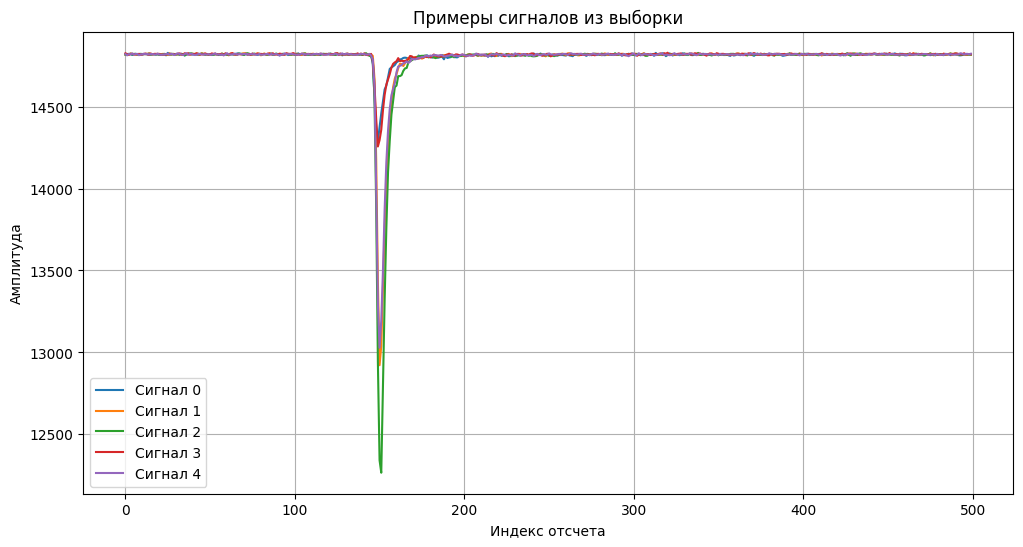

In [17]:
# Визуализация нескольких сигналов
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(signals.iloc[i, :].values, label=f'Сигнал {i}')
plt.title('Примеры сигналов из выборки')
plt.xlabel('Индекс отсчета')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)
plt.show()

---
Feature Engineering
--
---

In [18]:
# Нормализация сигналов
scaler = MinMaxScaler()
signals_scaled = scaler.fit_transform(signals)
signals_scaled = pd.DataFrame(signals_scaled)

In [19]:
# Функция для вычисления количества пересечений среднего
def calc_zero_crossings(signal):
    mean_val = np.mean(signal)
    return np.sum((signal[:-1] - mean_val) * (signal[1:] - mean_val) < 0)


In [20]:
# Функция для расчета ширины пика на полувысоте (FWHM)
def calc_fwhm(signal):
    peak_idx = np.argmax(signal)
    half_max = signal[peak_idx] / 2
    left_idx = np.where(signal[:peak_idx] <= half_max)[0]
    right_idx = np.where(signal[peak_idx:] <= half_max)[0]
    if left_idx.size == 0 or right_idx.size == 0:
        return 0
    return (peak_idx - left_idx[-1]) + (right_idx[0])

In [21]:
# Извлечение признаков
features = pd.DataFrame()
features['mean'] = signals_scaled.mean(axis=1)
features['std'] = signals_scaled.std(axis=1)
features['min'] = signals_scaled.min(axis=1)
features['max'] = signals_scaled.max(axis=1)
features['median'] = signals_scaled.median(axis=1)
features['percentile_25'] = signals_scaled.quantile(0.25, axis=1)
features['percentile_75'] = signals_scaled.quantile(0.75, axis=1)
features['skewness'] = signals_scaled.apply(skew, axis=1)
features['kurtosis'] = signals_scaled.apply(kurtosis, axis=1)
features['num_peaks'] = signals_scaled.apply(lambda x: len(find_peaks(x)[0]), axis=1)
features['zero_crossings'] = signals_scaled.apply(calc_zero_crossings, axis=1)
features['fwhm'] = signals_scaled.apply(calc_fwhm, axis=1)


In [22]:
# Заполняем возможные пропуски нулями
features = features.fillna(0)

print('Признаки извлечены.')
features.head()

Признаки извлечены.


,mean,std,min,max,median,percentile_25,percentile_75,skewness,kurtosis,num_peaks,zero_crossings,fwhm
0,0.657870,0.192457,0.095238,0.987470,0.685714,0.524702,0.798485,-0.442832,-0.522606,151,0,210
1,0.687919,0.173807,0.136364,0.983153,0.707108,0.571429,0.823529,-0.554769,-0.311698,153,0,0
2,0.671704,0.172622,0.142857,0.983073,0.689683,0.545455,0.812500,-0.417179,-0.579492,150,0,0
3,0.702950,0.171850,0.250000,0.987430,0.732520,0.598810,0.833333,-0.523065,-0.458196,144,0,322
4,0.676501,0.184783,0.095238,0.986763,0.699836,0.548864,0.820234,-0.542669,-0.414710,141,0,0


---
Визуализация
--
---

In [23]:
# PCA до 10 компонент
pca = PCA(n_components=10, random_state=42)
features_pca = pca.fit_transform(features)


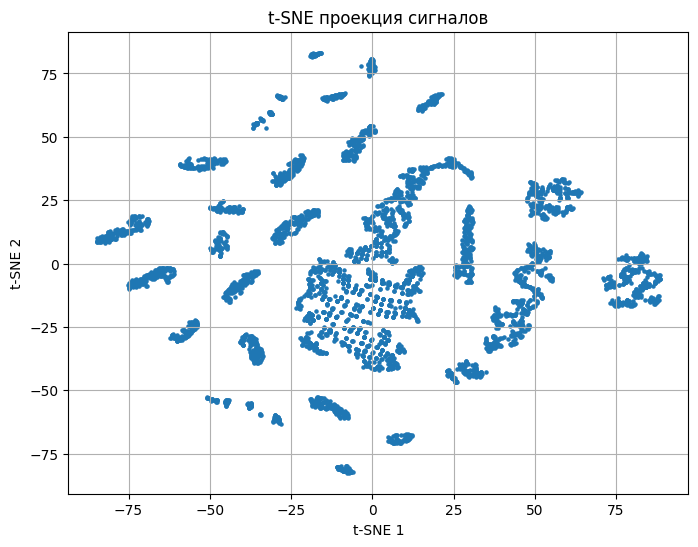

In [24]:
# t-SNE для визуализации (на подвыборке)
features_sampled = features.sample(n=5000, random_state=42)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(features_sampled)

plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], s=5)
plt.title('t-SNE проекция сигналов')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

---
Кластеризация
--
---

In [25]:
# Кластеризация методом KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

In [26]:
# Оценка кластеризации
silhouette = silhouette_score(features_pca, kmeans_labels)
ch_score = calinski_harabasz_score(features_pca, kmeans_labels)

print(f'Silhouette Score: {silhouette:.4f}')
print(f'Calinski-Harabasz Score: {ch_score:.2f}')

Silhouette Score: 0.7940
Calinski-Harabasz Score: 296876.50


---
Сохранение результата
--
---

In [27]:
# Переименование кластеров для правильной отправки
submission = pd.DataFrame({
    'index': data.index,
    'cluster': kmeans_labels
})

submission['activityID'] = -1
cluster_map = {}
next_activity_id = 0

for index, row in submission.iterrows():
    if row['cluster'] in cluster_map:
        submission.at[index, 'activityID'] = cluster_map[row['cluster']]
    else:
        cluster_map[row['cluster']] = next_activity_id
        submission.at[index, 'activityID'] = next_activity_id
        next_activity_id += 1

submission_final = submission[['index', 'activityID']]
submission_final.columns = ['index', 'cluster']

# Сохраняем файл
submission_final.to_csv('submission.csv', index=False)
print('Файл submission.csv сохранен для отправки на Kaggle.')

Файл submission.csv сохранен для отправки на Kaggle.
